# Introduction

With the outbreak of Covid-19, we believe that it is important for us to learn about how the computer recognizes whether a person is wearing a mask. The more accurate the algorithm, the better it serves to alert people as a protective precaution. In this project, we are going to implement machine learning models to explore the ways to execute mask classification with high accuracy. First, load the required packages.

In [54]:
# Make sure to upgrade TensorFlow to 2.7.0!!!
# conda activate PIC16B
# pip install tensorflow==2.7.0

# First we need to read in the required packages
import cv2,os
import numpy as np
# from tensorflow.keras.utils import np_utils
from tensorflow.keras import utils
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.pyplot as plt

In [36]:
print(tf.__version__)

2.7.0


# Data Visualization

* Our data set consists of images of faces with or without masks. The majority of images in our old dataset were created by manually pasting stickers of masks on faces. To make our model more convincing, we deleted all created images and added many real faces that wear masks.   
* Our data set now has approximately 1600 images for faces with masks and 951 images for faces without masks. 
* The following will be visualizations of some examples from our data set. 

**Here are some of the examples of images of faces without masks**

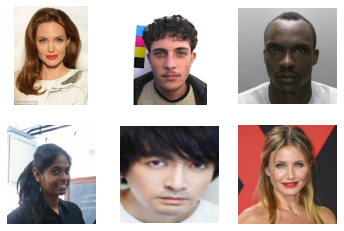

In [38]:
# List of file names
nomasks_list1 = ["data/without_mask/23.jpg", 
               "data/without_mask/29.jpg", 
               "data/without_mask/96.jpg", 
               "data/without_mask/22.jpg",
               "data/without_mask/0_0_zhangluyi_0082.jpg",
               "data/without_mask/74.jpg"]

# Loop through all images, display them
for i in range(6):   
    ax = plt.subplot(2, 3, i + 1)
    # read the image and show it 
    plt.imshow(mpimg.imread(nomasks_list1[i]))
    plt.axis("off")

#### Here are some of the examples of images of faces with masks

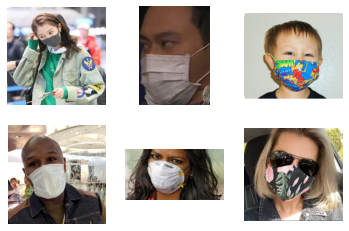

In [39]:
# List of file names
masks_list1 = ["data/with_mask/000 copy 36.jpg", 
               "data/with_mask/0_0_0 copy 21.jpg", 
               "data/with_mask/2398.png", 
               "data/with_mask/with_mask381.jpg",
               "data/with_mask/with_mask316.jpg",
               "data/with_mask/0502.png"]

# Loop through all images, display them
for i in range(6):   
    ax = plt.subplot(2, 3, i + 1)
    # read the image and show it 
    plt.imshow(mpimg.imread(masks_list1[i]))
    plt.axis("off")

# Data Preprocessing

Now we will define a function that can be used to process our data before training our model 

In [55]:
def DataPreprocess(data_path):
    """
    This function will loop through the data set, preprocess each image
    The input is the path to the data set
    We resize the image to a smaller size to speed up training
    The output will be images and targets in array form
    """
    # Create an empty dictionary to store data
    data_path  = data_path
    categories = ['without_mask', 'with_mask']
    # labels: without_mask, with_mask
    labels = [i for i in range(0, len(categories))]
    # Create an empty dictionary with keys = labels
    label_dict = dict(zip(categories,labels))
    print(label_dict)
    print(categories)
    print(labels)
    # Now loop through the datasets, preprocess each image, 
    # and append the preprocessed image to the empty dictionary created above
    img_size=160
    data=[]
    target=[]
    for category in categories:
        # Construct path to each folder ('without_mask', 'with_mask')
        folder_path=os.path.join(data_path,category)
        img_names=os.listdir(folder_path)
        # Remove ".DS_Store" from the list of image names
        if '.DS_Store' in img_names:
            img_names.remove('.DS_Store')
        # Loop through images in each folder
        for img_name in img_names:
            img_path=os.path.join(folder_path,img_name)
            img=cv2.imread(img_path)
            try:                
                # Resizing the image into 160x160         
                resized=cv2.resize(img,(img_size,img_size))
                # appending the image and the label(categorized) into the list (dataset)
                data.append(resized)
                target.append(label_dict[category])
            except Exception as e:
                print(img_name)
                print('Exception:',e)
                #if any exception rasied, the exception will be printed here.
   
    # now in this part we convert the images and targets into array form, 
    data=np.array(data)
    target=np.array(target)
    return data, target

Now we will preprocess the data set that we will be used to train the model.

In [56]:
data, target = DataPreprocess("data")

{'without_mask': 0, 'with_mask': 1}
['without_mask', 'with_mask']
[0, 1]


Let us see what is the baseline performance 

In [42]:
# baseline performance
sum(target)/len(target)

0.6314127861089187

After preprocessing out data, we need to split data into training and testing sets before buidling and training our model. We split with the ratio 9:1.

In [43]:
# Split data into training & testing sets
train_data,test_data,train_target,test_target=train_test_split(data,target,test_size=0.1)

# Data Augmentation

Since we want to add some data augmentation layers to our model, we will first experiment wil these layers. 
* First, we will create a tf.keras.layers.RandomFlip() layer. Then plot of the original image versus when RandomFlip() has been applied.

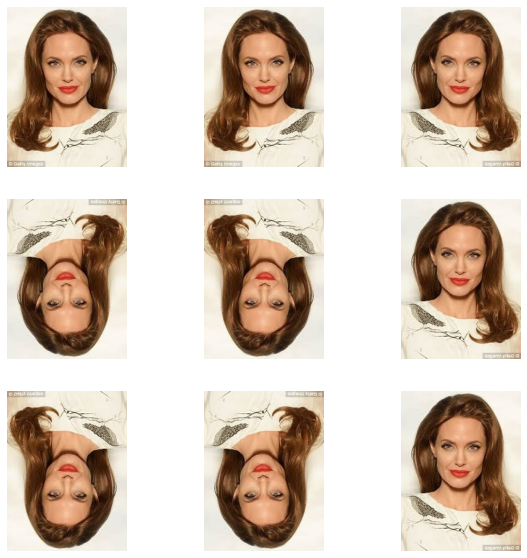

In [44]:
RandomFlip = tf.keras.layers.RandomFlip()
plt.figure(figsize=(10, 10))
image = mpimg.imread("data/without_mask/23.jpg")
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = RandomFlip(tf.expand_dims(image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')

* Then we will create a tf.keras.layers.RandomRotation() layer and make a plot of the original image versus the rotated ones.

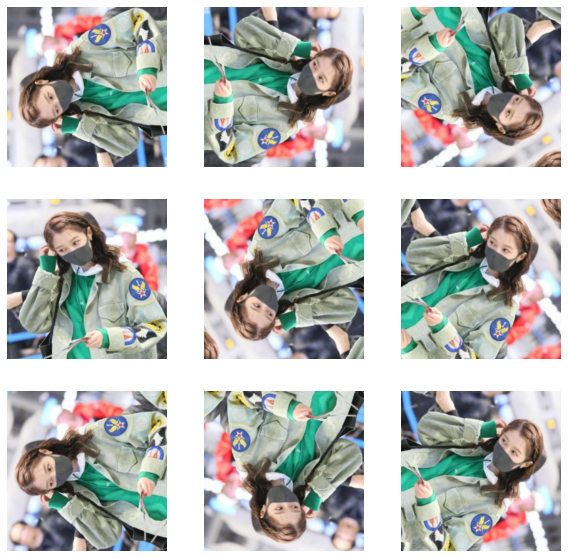

In [45]:
RandomRotation = tf.keras.layers.RandomRotation(0.5)
plt.figure(figsize=(10, 10))
image = mpimg.imread("data/with_mask/000 copy 36.jpg")
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = RandomRotation(tf.expand_dims(image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')

# Machine Learning Model

We will create a tf.keras.Sequential model using both a preprocessor, data augmentation layers, and also some of layers that we have discussed in class

In [69]:
"""
In our model we include:
1. a preprocessor
2. data augmentation: randomly flipping & rotating the images
3. two convolutional 2D layers
4. two max pooling layers
5. two dropout layers to avoid overfitting 
6. a flatten layer
7. and finally two dense layers to match the number of classes in the output
"""
img_size=160
# create a preprocessing layer
i = tf.keras.Input(shape=(img_size, img_size, 3))
x = tf.keras.applications.mobilenet_v2.preprocess_input(i)
preprocessor = tf.keras.Model(inputs = [i], outputs = [x])

model = tf.keras.Sequential([
    # preprocessing
    preprocessor,
    # data augmentation with flip and rotation
    layers.RandomFlip('horizontal'), 
    layers.RandomRotation(0.05),
    # The first CNN layer is a Convolution layer of a kernel size 3*3
    # It learns the base features and applies'relu' nonlinear transformation.
    # Also specifying the input shape here to be 160
    layers.Conv2D(32, (3,3), activation=layers.LeakyReLU(), input_shape=data.shape[1:]),
    # MaxPooling2D((2, 2)) 2*2 the size of window to find the max
    layers.MaxPooling2D((2, 2)),
    # layers.Dropout(0.5) force the model to not fit too closely, help relieve overfitting
    # layers.Dropout(0.5),
    # The second convolution layer
    layers.Conv2D(64, (3,3), activation=layers.LeakyReLU()),
    # MaxPooling layer
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3,3), activation=layers.LeakyReLU()),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(256, (3,3), activation=layers.LeakyReLU()),
    # Flatten layer to stack the output convolutions from second convolution layer
    layers.Flatten(),
    # Dense layer of 512 neurons
    layers.Dense(512, activation=layers.LeakyReLU()),    
    # layers.Dropout(0.5) force the model to not fit too closely, help relieve overfitting
    layers.Dropout(0.5),
    layers.Dense(2, activation='softmax')
])

In [68]:
img_size

160

In [70]:
model.build(data.shape)
model.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 model_10 (Functional)       (None, 160, 160, 3)       0         
                                                                 
 random_flip_10 (RandomFlip)  (None, 160, 160, 3)      0         
                                                                 
 random_rotation_10 (RandomR  (None, 160, 160, 3)      0         
 otation)                                                        
                                                                 
 conv2d_20 (Conv2D)          (None, 158, 158, 32)      896       
                                                                 
 max_pooling2d_18 (MaxPoolin  (None, 79, 79, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_21 (Conv2D)          (None, 77, 77, 64)       

Now we will train model and plot the history of the accuracy on both the training and validation sets. 

In [71]:
# compile the model
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
# from_logits=True compute softmax when evaluting loss function
# metrics=['accuracy'] want to see how accurate on the data

# fit the model on 80% of the training set, evaluate on the rest
history = model.fit(train_data,
                     train_target, 
                     epochs=20,
                     validation_split=0.2)

Epoch 1/20
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
57/57 [==============================] - ETA: 0s - loss: 0.8514 - accuracy: 0.8185WARNING:tensorflow:AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x1544518c0> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and att

From the output, we can see that despite that there are some fluctuations in the first few epochs, the validation accuracy of the model stabilizes to a decent leve of well above 90 percent. A visualization of the training history is as follows.

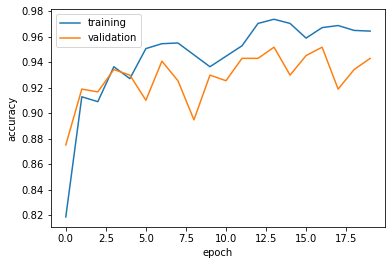

In [72]:
"""
Our results proved to be pretty precise and there
is no apparent sign of overfitting.
"""
plt.plot(history.history["accuracy"], label = "training")
plt.plot(history.history["val_accuracy"], label = "validation")
plt.gca().set(xlabel = "epoch", ylabel = "accuracy") # gca: get current axis 
plt.legend()

We see that training accuracy was around 96%, and validation accuracy was around 93-94%. Validation accuracy seems to be a bit unstable. This may be explained by the stochastic nature of the optimization process (i.e., stochastic gradient descent). However, it did stabilize at around 93-94%. 

Now we will evaluate the accuracy of the model on the test dataset

In [31]:
print(model.evaluate(test_data,test_target))

8/8 [==============================] - 1s 146ms/step - loss: 0.1290 - accuracy: 0.9453
[0.1290377378463745, 0.9453125]


The model achieved 95% accuracy on the unseen test dataset. Amazing!

# Testing Model on Data Sets of Different Racial Groups

* Besides examining the performance on all people comprehensively, we would also like to see if different skin colors and facial characteristics across races might affect the model's performance. 
* We now test our model on Black, White, and Asian people separately to analyze whether our algorithm is biased. We will preprocess each data set and then test our model.

In [73]:
categories = ['without_mask', 'with_mask']

In [84]:
def testing(data_path, model):
    """
    This function will preprocess the data set, test the model on the data set, 
    and create visualization
    """
    # preprocess the data
    data_test, target_test = DataPreprocess(data_path)
    # Test model on the data set
    print(model.evaluate(data_test, target_test))
    # visualize
    y_pred = model.predict(data_test)
    labels_pred = y_pred.argmax(axis = 1)
    plt.figure(figsize=(10,10))
    for i in range(30):
        if i < 15:
            plt.subplot(6,5,i+1)
            plt.xticks([])
            plt.yticks([])
            plt.grid(False)
            plt.imshow(data_test[i])
            plt.xlabel(categories[labels_pred[i]])
        else:
            plt.subplot(6,5,i+1)
            plt.xticks([])
            plt.yticks([])
            plt.grid(False)
            plt.imshow(data_test[i+25])
            plt.xlabel(categories[labels_pred[i+25]])

#### 1. Data set containing faces of black people wearing masks and not wearing masks

{'without_mask': 0, 'with_mask': 1}
['without_mask', 'with_mask']
[0, 1]
2/2 [==============================] - 0s 138ms/step - loss: 0.6066 - accuracy: 0.8475
[0.6065927743911743, 0.8474576473236084]
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


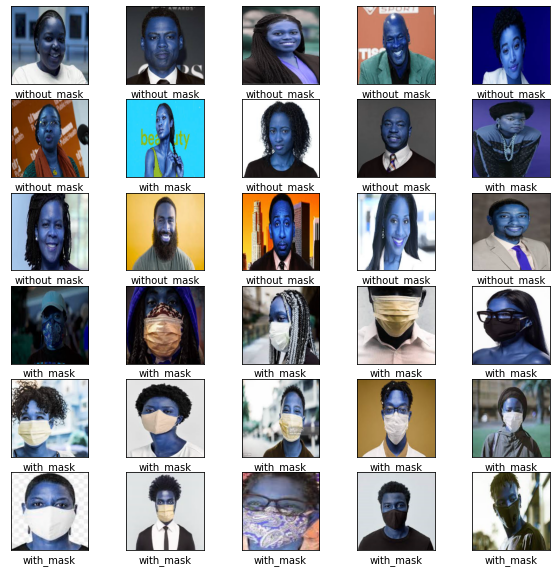

In [75]:
testing("data/Testing_Black", model)

#### 2. Data set containing faces of East Asia people wearing masks and not wearing masks

{'without_mask': 0, 'with_mask': 1}
['without_mask', 'with_mask']
[0, 1]
2/2 [==============================] - 0s 145ms/step - loss: 0.6504 - accuracy: 0.8500
[0.6503875255584717, 0.8500000238418579]


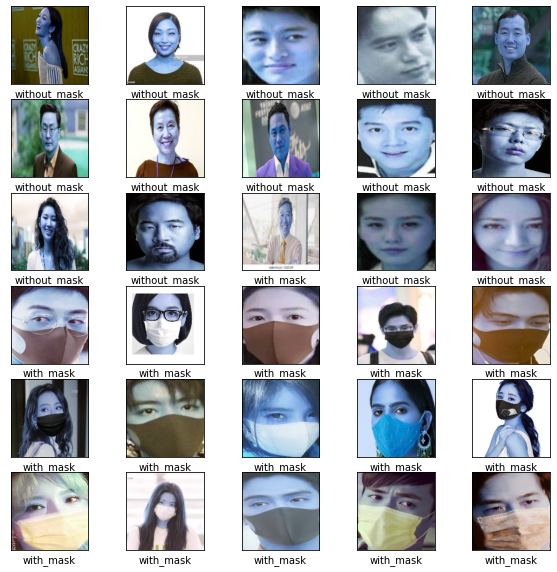

In [79]:
testing("data/Testing_Asian", model)

#### 3. Data set containing faces of White people wearing masks and not wearing masks

{'without_mask': 0, 'with_mask': 1}
['without_mask', 'with_mask']
[0, 1]
2/2 [==============================] - 0s 117ms/step - loss: 0.2074 - accuracy: 0.9455
[0.207426980137825, 0.9454545378684998]


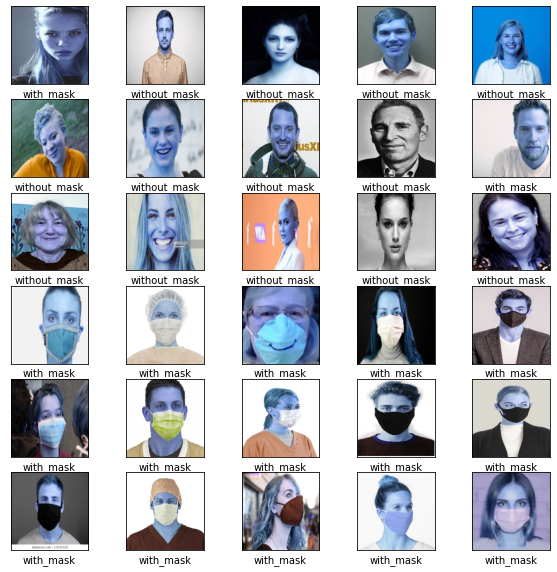

In [78]:
testing("data/Testing_White", model)

We can see that our model performs best on white people with around 95% accuracy. It also shows around 85% accuracy on Asian and black people. The lower accuracy for black people compared to white people might result from a lower percentage of black people's photos in the training dataset. It is interesting that we observed lower accuracy for Asian people as well, even though their images are the most abundant in the training dataset. One reason for this could be that Asian people constitute a pretty heterogeneous group. For example, East Asian and South Asian people look very different from each other. East Asian people are over-represented in our training dataset, whereas others are less so, and the lower prediction accuracy for other Asian subgroups may have contributed to the overall lower accuracy for Asian people.
With these limitations in mind, we believe incorporating more data of black people and other Asian subgroups will help address the racial bias.

# Transfer Learning Using MobileNet V2

Finally, we sought to use a more sophisticated, pre-trained model to address the observed racial bias. We used MobileNet V2.

In [80]:
IMG_SHAPE = (160, 160, 3)
# load MobileNetV2 model
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')
# freeze the base model
base_model.trainable = False
# build a layer using the imported MobileNetV2 model
i = tf.keras.Input(shape=IMG_SHAPE)
x = base_model(i, training = False)
base_model_layer = tf.keras.Model(inputs = [i], outputs = [x])

9420800/9406464 [==============================] - 1s 0us/step


We will now construct a new model that contains the preprocessor and data augmentation layers we created before, the MobileNetV2 layer, a GlobalMaxPooling2D layer, and a Dense layer.

In [81]:
# build a new model using transfer learning
model_transfer = models.Sequential([
    # preprocessing layer
    preprocessor,
    # data augmentation
    layers.RandomFlip('horizontal'), 
    layers.RandomRotation(0.05),
    # MobileNetV2 layer
    base_model_layer,
    # GlobalMaxPooling layer to reduce dimensionality
    layers.GlobalMaxPooling2D(),
    # Dense layer
    layers.Dense(2),
])

In [82]:
# compile the model
model_transfer.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
# from_logits=True compute softmax when evaluting loss function
# metrics=['accuracy'] want to see how accurate on the data

# fit the model on 80% of the training set, evaluate on the rest
history_transfer = model_transfer.fit(train_data,
                     train_target, 
                     epochs=20,
                     validation_split=0.2)

Epoch 1/20
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
57/57 [==============================] - ETA: 0s - loss: 0.7616 - accuracy: 0.7999WARNING:tensorflow:AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x14d8dda70> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and att

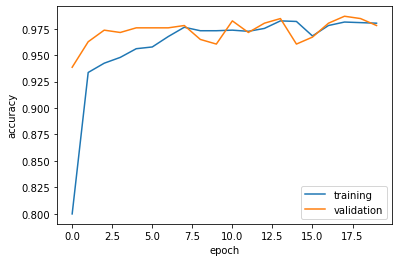

In [83]:
"""
Our results proved to be pretty precise and there
is no apparent sign of overfitting.
"""
plt.plot(history_transfer.history["accuracy"], label = "training")
plt.plot(history_transfer.history["val_accuracy"], label = "validation")
plt.gca().set(xlabel = "epoch", ylabel = "accuracy") # gca: get current axis 
plt.legend()

Indeed, our new model seems to have outperformed the original model, both in terms of validation accuracy and overfitting.

# Testing Transfer Learning Model on Datasets of Different Racial Groups

{'without_mask': 0, 'with_mask': 1}
['without_mask', 'with_mask']
[0, 1]
2/2 [==============================] - 1s 251ms/step - loss: 0.1115 - accuracy: 0.9661
[0.11148443073034286, 0.9661017060279846]
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


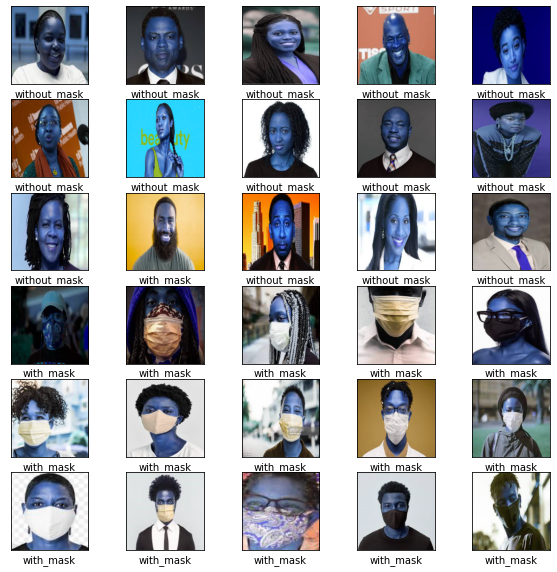

In [85]:
# testing on black people
testing("data/Testing_Black", model_transfer)

{'without_mask': 0, 'with_mask': 1}
['without_mask', 'with_mask']
[0, 1]
2/2 [==============================] - 1s 254ms/step - loss: 0.1979 - accuracy: 0.9500
[0.19792117178440094, 0.949999988079071]


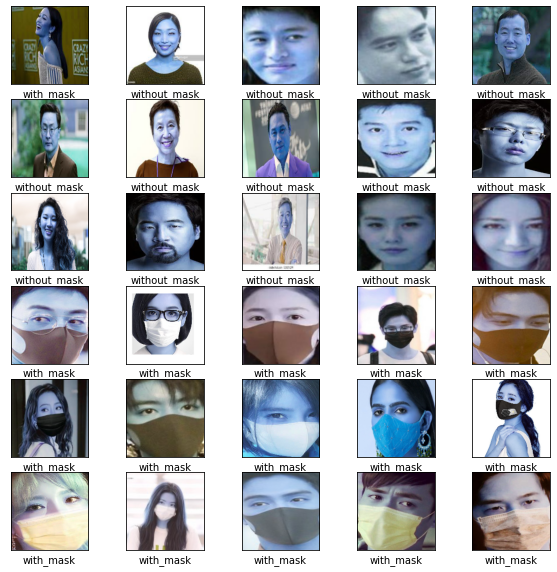

In [86]:
# testing on Asian people
testing("data/Testing_Asian", model_transfer)

{'without_mask': 0, 'with_mask': 1}
['without_mask', 'with_mask']
[0, 1]
2/2 [==============================] - 1s 209ms/step - loss: 0.1001 - accuracy: 0.9636
[0.10009092092514038, 0.9636363387107849]


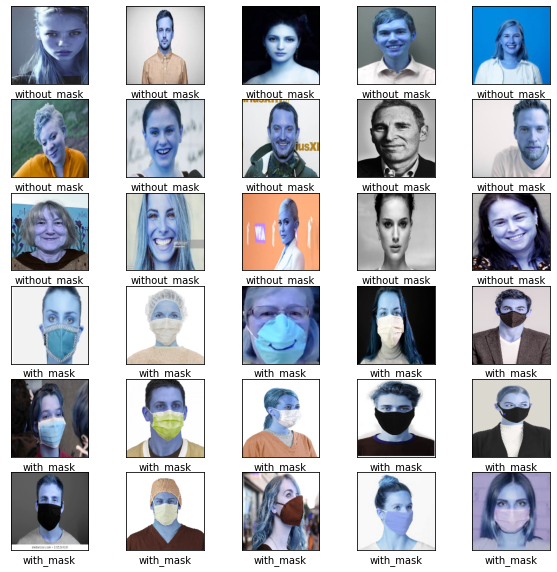

In [87]:
# testing on white people
testing("data/Testing_White", model_transfer)

Overall, the transfer learning model performed equally well on all racial groups, with an accuracy level of around 95~96%.

# Limitations and Future Directions

- As the test accuracies suggested, our model performed less well on differentiating black and white people with vs. without masks. This may be because there are more Asian people in our "with_mask" training dataset than people of other racial groups. We did attempt to balance the number of people of different racial groups who are wearing masks, but since no existing dataset that contains **real**, as opposed to synthetic, images of masks is racially diverse, for the racial minority groups we had to find individual photos ourselves. And, it was harder to find black people with masks on Google Images. 
    - Future direction: Spend more time curating a more racially and ethnically balanced dataset.

- The current model is limited to classifying **static** images of people with and without masks. In reality, a face mask classifier would receive **dynamic**, **online** inputs.
    - Future direction: Develop an algorithm that can signal whether someone is wearing a mask real time in a video. This could be done by repeatedly deploying the current algorithm on each frame of the video.

- Currently, the model can only tell apart masks vs. without masks. But, it cannot differentiate different types of facial covering (e.g., masks, bandanas, scarves). As we know, masks are more effective in preventing the spread of COVID-19 than other types of facial coverings. 
    - Future direction: Develop a face mask **detector**, as opposed to **classifier**. This may benefit from using OpenCV.
    
- Our current model is better at detecting masks in the frontal direction of the face but not as well when it faces sideways. From other models and datasets we used in training, the accuracy seems to be positively correlated with the size and clarity of the facial part in the image.
    - Future direction: If we had the time and bandwidth, we could try using images with better quality and resize it to a larger size. We would also like to add a greater proportion of faces facing other directions into our training set to account for more variability.

- Some people cannot wear masks due to medical/religious reasons. 
    - Future direction: Although it would be hard to develop an algorithm that can tell if someone has a medical condition  that makes them unable to wear masks, we know that certain populations just cannot wear masks (e.g., children < 2yrs). So, it might be worthwhile to develop a face mask detector that does not display warnings when a toddler is not wearing a mask. This would involve training the algorithm to differentiate facial features on top of having masks or not.